In [1]:
import pandas as pd
import regex as re

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import ahocorasick

import torch
from transformers import T5ForConditionalGeneration, AutoTokenizer, MT5ForConditionalGeneration, get_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
#from fairseq.optim.adafactor import Adafactor

from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
# CONSTANTS:

SEP_TOKEN = '▁<extra_id_0>'
INPUT_PREFIX = ''

NUM_OF_SPLITS = 10

ATTACHMENT_TOKEN = '▁<extra_id_1>'

USED_MODEL_NAME = 'cointegrated/rut5-small'

SEQ_MAX_LENGTH = 300
ANSWER_MAX_LENGTH = 170
BATCH_SIZE = 4
EVAL_BATCH_SIZE = 16

ENABLE_LABEL_FIX = True

LOCAL_NUM_EPOCHS = 5

In [3]:
tokenizer = AutoTokenizer.from_pretrained (USED_MODEL_NAME)

device = torch.device ('cuda' if torch.cuda.is_available () else 'cpu')
#device = torch.device ('cpu')

model = MT5ForConditionalGeneration.from_pretrained (USED_MODEL_NAME)

model.to (device)
print (model.device)

num_epochs = 50
#training_steps = len (train_data ['input_ids']) // BATCH_SIZE * num_epochs
#warmup_steps = int (training_steps * 0.1)
#print (f'Suggested train steps: {training_steps}\n\t warmup steps: {int (training_steps * 0.05)} - {int (training_steps * 0.1)}')

#optimizer = AdamW (model.parameters (), lr = 1e-5)#, weight_decay = 0.05)
optimizer = AdamW (filter (lambda p: p.requires_grad, model.parameters ()), lr = 1e-4, weight_decay = 0.01)
#optimizer = Adafactor (model.parameters (), lr = 3e-5, scale_parameter = False, relative_step = False, weight_decay = 0.02)
#scheduler = get_scheduler ('linear', optimizer = optimizer, num_warmup_steps = warmup_steps, num_training_steps = training_steps)

metrics = {'train_loss': [], 'val_loss': [], 'precision': [], 'recall': [], 'f1_score': []}

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
c:\Users\Enfi\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


cuda:0


In [4]:

# FUNCTIONS:

def split_text (text, segments, delimiters = ['...', '.', '?!', '?', '!']):

    delimiters_pattern = '|'.join (map (re.escape, delimiters))
    
    paragraphs = re.split (f'(?<=\n[ ]*)', text)
    
    sentences_with_segments = []
    
    current_start_index = 0

    for paragraph in paragraphs:

        sentences = re.split (f'(?<=[{delimiters_pattern}] )(?=[A-ZА-ЯЁ])', paragraph)#.strip ())

        for sentence in sentences:

            start_index = current_start_index
            end_index = start_index + len (sentence)

            matched_segments = [
                text [start: end] for start, end in segments if start >= start_index and end <= end_index
            ]
            sentences_with_segments.append ((sentence, matched_segments))

            current_start_index = end_index
    
    return sentences_with_segments

def create_parallels (data_lst, labels_lst):
    parallel_text = []
    parallel_label = []
    for i in range (len (data_lst)):
        text = data_lst [i]
        segments = labels_lst [i]
        splitted = split_text (text, segments)
        for sentence, terms in splitted:
            parallel_text.append (INPUT_PREFIX + sentence)
            constructed_label = ''
            for term in terms:
                constructed_label += term.strip () + SEP_TOKEN
            if len (constructed_label) > 0:
                parallel_label.append (constructed_label [: - len (SEP_TOKEN)])
            else:
                parallel_label.append ('')
    return parallel_text, parallel_label


def label_constructor (labels):
    res = []
    for label in labels:
        one_label = []
        for start, end, cls in label:
            one_label.append ([start, end])
        res.append (one_label)
    return res


def one_finder (text, phrases):

    if len (phrases) == 1 and '' in phrases:
        return []

    A = ahocorasick.Automaton ()
    
    for idx, phrase in enumerate (phrases):
        A.add_word (phrase, (idx, phrase))
    
    A.make_automaton ()
    
    found = []
    for end_index, (idx, phrase) in A.iter (text):
        start_index = end_index - len (phrase) + 1

        if start_index > 0 and text [start_index - 1].isalpha ():
            continue
        if end_index + 1 < len (text) and text [end_index + 1].isalpha ():
            continue

        found.append ((start_index, end_index + 1, phrase))
    
    return found

def make_attachment (text, dictionary_terms):
    found = one_finder (text, dictionary_terms)
    found_terms = [item [2] for item in found]
    res = text + ATTACHMENT_TOKEN
    for term in found_terms:
        res += term + SEP_TOKEN
    if len (found_terms) > 0:
        res = res [: - len (SEP_TOKEN)]
    return res

def attach_dictionary_foundings (texts, dictionary_terms):
    res_texts = []
    for text in tqdm (texts):
        res_texts.append (make_attachment (text, dictionary_terms))
    return res_texts

def replace_padding (labels):
    for i in range (0, len (labels ['input_ids'])):
        labels ['input_ids'] [i] = torch.tensor ([labl if labl != 0 else - 100 for labl in labels ['input_ids'] [i]])

    return labels

class Seq2SeqDataset (Dataset):
    def __init__ (self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__ (self, idx):
        return {
            'input_ids': self.encodings ['input_ids'] [idx],
            'attention_mask': self.encodings ['attention_mask'] [idx],
            'labels': self.labels ['input_ids'] [idx]
        }

    def __len__ (self):
        return len (self.encodings ['input_ids'])

def get_set (tensor, ground_truth = True, tokenizer = tokenizer):

    separator: str
    if SEP_TOKEN == '▁<extra_id_0>': separator = '<extra_id_0>'
    else: separator = SEP_TOKEN

    res: set

    if ground_truth:
        eos_idx = (tensor == 1).nonzero ()
        if eos_idx.numel () > 0:
            eos_idx = int (eos_idx [0] [0])
        else:
            eos_idx = len (tensor)
        seq = tensor [:eos_idx]
    
    else:
        seq = tensor [tensor != 0]
        seq = seq [seq != - 100]   ### WHAT?!
        seq = seq [seq != 1]
    
    txt = tokenizer.decode (seq)
    res = set ([item.strip () for item in txt.split (separator)])

    if len (res) > 1:
        res -= set ([''])

    return res


def sanity_check (preds, labels, to_print = False):

    tps_sum = 0
    fps_sum = 0
    fns_sum = 0 

    for i in range (len (labels)):
        predicted_set = get_set (preds [i], ground_truth = False)
        true_set = get_set (labels [i])

        if to_print: print (f'True: {true_set}\nPred: {predicted_set}')

        tps_sum += len (true_set & predicted_set)  # Истинно положительные
        fps_sum += len (predicted_set - true_set)     # Ложноположительные
        fns_sum += len (true_set - predicted_set)     # Ложноотрицательные

    precision = tps_sum / (tps_sum + fps_sum) if (tps_sum + fps_sum) > 0 else 0
    recall = tps_sum / (tps_sum + fns_sum) if (tps_sum + fns_sum) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score

In [5]:
df = pd.read_json ('train_t1_v1.jsonl', lines = True)
df.drop (columns = ['id', 'keywords'], inplace = True)
print (df.head ())
print ()
df_2 = pd.read_json ('./test_data/test1_t12_full_v2.jsonl', lines = True)
df_2 = df_2 [['text', 'label']]
print (df_2.head ())
print ()

val_data_txt, test_data_txt, val_labels_txt, test_labels_txt = train_test_split (df_2 ['text'], df_2 ['label'], test_size = 0.5, random_state = 14)

train_data_lst = df ['text'].tolist ()
train_labels_lst = df ['label'].tolist ()
train_parallel_text, train_parallel_labels = create_parallels (train_data_lst, train_labels_lst)

val_data_lst = val_data_txt.tolist ()
val_labels_lst = label_constructor (val_labels_txt)
val_parallel_text, val_parallel_labels = create_parallels (val_data_lst, val_labels_lst)

test_data_lst = test_data_txt.tolist ()
test_labels_lst = label_constructor (test_labels_txt)
test_parallel_text, test_parallel_labels = create_parallels (test_data_lst, test_labels_lst)

all_train_terms = set ()
for line in train_parallel_labels:
    all_train_terms |= set (line.split (SEP_TOKEN))
all_train_terms -= set ([''])
print (f'Уникальных терминов во всём тренировочном наборе: {len (all_train_terms)}.\n')

val_parallel_text_new = attach_dictionary_foundings (val_parallel_text, all_train_terms)
test_parallel_text_new = attach_dictionary_foundings (test_parallel_text, all_train_terms)

val_data = tokenizer (val_parallel_text_new, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
val_labels = tokenizer (val_parallel_labels, padding = 'max_length', truncation = True, max_length = ANSWER_MAX_LENGTH, return_tensors = 'pt')

test_data = tokenizer (test_parallel_text_new, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
test_labels = tokenizer (test_parallel_labels, padding = 'max_length', truncation = True, max_length = ANSWER_MAX_LENGTH, return_tensors = 'pt')

if ENABLE_LABEL_FIX:
    
    replaced = replace_padding (val_labels)
    val_labels = replaced

    replaced = replace_padding (test_labels)
    test_labels = replaced

val_dataset = Seq2SeqDataset (val_data, val_labels)
test_dataset = Seq2SeqDataset (test_data, test_labels)

val_loader = DataLoader (val_dataset, batch_size = EVAL_BATCH_SIZE)
test_loader = DataLoader (test_dataset, batch_size = EVAL_BATCH_SIZE)

                                                text  \
0  ABBYY Retrieval & Morphology Engine\nВ сообщен...   
1  Речевые формулы в диалоге\nПредложенная класси...   
2  Географические названия и полнотекстовые докум...   
3  Методы автоматического построения специализиро...   
4  Закономерности построения дискурсивной последо...   

                                               label  
0  [[0, 35], [6, 15], [18, 35], [29, 35], [69, 88...  
1  [[0, 15], [18, 25], [74, 99], [134, 140], [175...  
2  [[0, 23], [26, 50], [54, 68], [169, 190], [181...  
3  [[7, 63], [34, 63], [54, 63], [92, 128], [119,...  
4  [[26, 57], [62, 76], [251, 265], [266, 280], [...  

                                                text  \
0  АВТОМАТИЧЕСКИЙ АНАЛИЗ ТОНАЛЬНОСТИ ТЕКСТОВ НА О...   
1  InBASE: ТЕХНОЛОГИЯ ПОСТРОЕНИЯ ЕЯ-ИНТЕРФЕЙСОВ К...   
2  Выражение уважительности с помощью личных мест...   
3  ДА ЧЕРТ ЛИ В ДЕТАЛЯХ?.. МЕРА ДЛЯ ОЦЕНКИ СОВПАД...   
4  КОРПУСНАЯ ОЦЕНКА СОЧЕТАЕМОСТИ СЛОВ С ИСПОЛЬЗОВ...

100%|██████████| 695/695 [00:08<00:00, 83.31it/s]


In [ ]:
kf = KFold (n_splits = NUM_OF_SPLITS)

data = df ['text']
labels = df ['label']

inc_term_set = set ()
for iteration, (train_index, test_index) in enumerate (kf.split (data)):
    X_curr = data [test_index]
    y_curr = labels [test_index]

    train_data_lst = X_curr.tolist ()
    train_labels_lst = y_curr.tolist ()
    parallel_text, parallel_labels = create_parallels (train_data_lst, train_labels_lst)
    
    if iteration == 0:
        for line in parallel_labels:
            inc_term_set |= set (line.split (SEP_TOKEN))
        inc_term_set -= set ([''])
        print (f'Уникальных терминов в {iteration + 1}-м тренировочном наборе: {len (inc_term_set)}.')
        continue

    parallel_text_new = attach_dictionary_foundings (parallel_text, inc_term_set)

    train_data = tokenizer (parallel_text_new, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
    train_labels = tokenizer (parallel_labels, padding = 'max_length', truncation = True, max_length = ANSWER_MAX_LENGTH, return_tensors = 'pt')
    
    if ENABLE_LABEL_FIX:
        replaced = replace_padding (train_labels)
        train_labels = replaced

    train_dataset = Seq2SeqDataset (train_data, train_labels)
    train_loader = DataLoader (train_dataset, batch_size = BATCH_SIZE, shuffle = True)

    for epoch in range (LOCAL_NUM_EPOCHS):
        model.train ()  # Устанавливаем модель в режим обучения
        total_loss = 0
        
        for batch in tqdm (train_loader):
            
            input_ids = batch ['input_ids'].to (model.device)
            attention_mask = batch ['attention_mask'].to (model.device)
            labels_fromdata = batch ['labels'].to (model.device)

            outputs = model (input_ids = input_ids, attention_mask = attention_mask, labels = labels_fromdata)
            loss = outputs.loss   ## DOUBLE CHECK if padding ...
            total_loss += loss.item ()

            loss.backward ()  # Обратное распространение
            optimizer.step ()  # Обновление параметров
            optimizer.zero_grad ()  # Обнуляем градиенты

            #scheduler.step ()  # Обновление learning rate
            torch.cuda.empty_cache ()
        

        avg_loss = total_loss / len (train_loader)

        metrics ['train_loss'].append ((58+epoch + (iteration - 1) * LOCAL_NUM_EPOCHS, avg_loss))

        # Оценка на валидационной выборке
        model.eval ()  # Устанавливаем модель в режим оценки
        val_preds, val_labels = [], []
        total_val_loss = 0

        with torch.no_grad ():
            for batch in val_loader:
                input_ids = batch ['input_ids'].to (model.device)
                attention_mask = batch ['attention_mask'].to (model.device)
                labels_fromdata = batch ['labels'].to (model.device)

                outputs = model.generate (input_ids = input_ids, attention_mask = attention_mask)

                total_val_loss += model (input_ids = input_ids, attention_mask = attention_mask, labels = labels_fromdata).loss.item ()

                val_preds.extend (outputs)
                val_labels.extend (labels_fromdata)
                torch.cuda.empty_cache ()

        avg_val_loss = total_val_loss / len (val_loader)

        prec, recl, f1sc = sanity_check (val_preds, val_labels)

        metrics ['val_loss'].append ((58+epoch + (iteration - 1) * LOCAL_NUM_EPOCHS, avg_val_loss))
        metrics ['precision'].append ((58+epoch + (iteration - 1) * LOCAL_NUM_EPOCHS, prec))
        metrics ['recall'].append ((58+epoch + (iteration - 1) * LOCAL_NUM_EPOCHS, recl))
        metrics ['f1_score'].append ((58+epoch + (iteration - 1) * LOCAL_NUM_EPOCHS, f1sc))

        print (f'Epoch {(57+epoch + 1) + (iteration - 1) * LOCAL_NUM_EPOCHS} / {57+(NUM_OF_SPLITS - 1) * LOCAL_NUM_EPOCHS}, Loss: {avg_loss:.4f}, Validation loss: {avg_val_loss:.4f}, {prec} / {recl} / {f1sc}')
        
        torch.cuda.empty_cache ()


    for line in parallel_labels:
        inc_term_set |= set (line.split (SEP_TOKEN))
    inc_term_set -= set ([''])
    print (f'Уникальных терминов в {iteration + 1}-м тренировочном наборе: {len (inc_term_set)}.')

Уникальных терминов в 1-м тренировочном наборе: 800.


100%|██████████| 60/60 [00:07<00:00,  8.55it/s]


Epoch 58 / 114, Loss: 0.5470, Validation loss: 0.5609, 0.5633507853403141 / 0.4498327759197324 / 0.5002324500232449


100%|██████████| 60/60 [00:06<00:00,  8.75it/s]


Epoch 59 / 114, Loss: 0.4417, Validation loss: 0.5741, 0.5690217391304347 / 0.43770903010033446 / 0.49480151228733454


100%|██████████| 60/60 [00:06<00:00,  8.90it/s]


Epoch 60 / 114, Loss: 0.4124, Validation loss: 0.5682, 0.566304347826087 / 0.43561872909698995 / 0.4924385633270322
Уникальных терминов в 2-м тренировочном наборе: 1529.


100%|██████████| 64/64 [00:07<00:00,  8.86it/s]


Epoch 61 / 114, Loss: 0.5251, Validation loss: 0.5593, 0.5862451469772602 / 0.4418896321070234 / 0.5039332538736592


100%|██████████| 64/64 [00:07<00:00,  8.78it/s]


Epoch 62 / 114, Loss: 0.4478, Validation loss: 0.5461, 0.585792349726776 / 0.44816053511705684 / 0.5078162008526764


100%|██████████| 64/64 [00:07<00:00,  8.96it/s]


Epoch 63 / 114, Loss: 0.3902, Validation loss: 0.5560, 0.5815098468271335 / 0.4443979933110368 / 0.5037914691943127
Уникальных терминов в 3-м тренировочном наборе: 2210.


100%|██████████| 69/69 [00:07<00:00,  8.89it/s]


Epoch 64 / 114, Loss: 0.5221, Validation loss: 0.5463, 0.5791974656810982 / 0.45861204013377926 / 0.511899206719552


100%|██████████| 69/69 [00:07<00:00,  8.82it/s]


Epoch 65 / 114, Loss: 0.4539, Validation loss: 0.5718, 0.5503355704697986 / 0.44565217391304346 / 0.4924924924924925


100%|██████████| 69/69 [00:07<00:00,  8.90it/s]


Epoch 66 / 114, Loss: 0.3876, Validation loss: 0.5833, 0.5434565434565435 / 0.45484949832775917 / 0.4952207555757852
Уникальных терминов в 4-м тренировочном наборе: 3002.


100%|██████████| 65/65 [00:07<00:00,  8.87it/s]


Epoch 67 / 114, Loss: 0.4542, Validation loss: 0.5689, 0.5809628008752735 / 0.4439799331103679 / 0.5033175355450237


100%|██████████| 65/65 [00:07<00:00,  8.64it/s]


Epoch 68 / 114, Loss: 0.4034, Validation loss: 0.5845, 0.5633802816901409 / 0.451505016722408 / 0.5012763982362497


100%|██████████| 65/65 [00:07<00:00,  8.93it/s]


Epoch 69 / 114, Loss: 0.3623, Validation loss: 0.6071, 0.5625 / 0.44021739130434784 / 0.4939024390243902
Уникальных терминов в 5-м тренировочном наборе: 3627.


100%|██████████| 45/45 [00:05<00:00,  8.69it/s]


Epoch 70 / 114, Loss: 0.4291, Validation loss: 0.5676, 0.592800899887514 / 0.4406354515050167 / 0.5055155875299762


100%|██████████| 45/45 [00:05<00:00,  8.94it/s]


Epoch 71 / 114, Loss: 0.3790, Validation loss: 0.5750, 0.5564516129032258 / 0.4326923076923077 / 0.486829727187206


100%|██████████| 45/45 [00:04<00:00,  9.19it/s]


Epoch 72 / 114, Loss: 0.3303, Validation loss: 0.5642, 0.5862258953168044 / 0.44481605351170567 / 0.5058236272878536
Уникальных терминов в 6-м тренировочном наборе: 4055.


100%|██████████| 50/50 [00:05<00:00,  8.92it/s]


Epoch 73 / 114, Loss: 0.4210, Validation loss: 0.5462, 0.6120309050772627 / 0.463628762541806 / 0.527592768791627


100%|██████████| 50/50 [00:05<00:00,  8.93it/s]


Epoch 74 / 114, Loss: 0.3671, Validation loss: 0.5448, 0.618458075407991 / 0.45944816053511706 / 0.5272247541376829


100%|██████████| 50/50 [00:05<00:00,  8.85it/s]


Epoch 75 / 114, Loss: 0.3086, Validation loss: 0.5768, 0.6192584394023243 / 0.467809364548495 / 0.5329840438199571
Уникальных терминов в 7-м тренировочном наборе: 4511.


100%|██████████| 44/44 [00:04<00:00,  8.89it/s]


Epoch 76 / 114, Loss: 0.3894, Validation loss: 0.5460, 0.5942558746736293 / 0.47575250836120403 / 0.5284420710471326


100%|██████████| 44/44 [00:04<00:00,  8.98it/s]


Epoch 77 / 114, Loss: 0.3352, Validation loss: 0.5431, 0.6260869565217392 / 0.4816053511705686 / 0.5444234404536862


100%|██████████| 44/44 [00:04<00:00,  9.14it/s]


Epoch 78 / 114, Loss: 0.2785, Validation loss: 0.5584, 0.6264737406216506 / 0.4887123745819398 / 0.5490840770314701
Уникальных терминов в 8-м тренировочном наборе: 4877.


100%|██████████| 42/42 [00:04<00:00,  9.04it/s]


Epoch 79 / 114, Loss: 0.3788, Validation loss: 0.5581, 0.6153034300791557 / 0.4874581939799331 / 0.5439701422906462


100%|██████████| 42/42 [00:04<00:00,  8.79it/s]


Epoch 80 / 114, Loss: 0.3385, Validation loss: 0.5552, 0.6124933827421917 / 0.483695652173913 / 0.540527914038776


100%|██████████| 42/42 [00:04<00:00,  8.75it/s]


Epoch 81 / 114, Loss: 0.2948, Validation loss: 0.5580, 0.6203703703703703 / 0.4761705685618729 / 0.5387890255439926
Уникальных терминов в 9-м тренировочном наборе: 5312.


100%|██████████| 44/44 [00:04<00:00,  8.90it/s]


Epoch 82 / 114, Loss: 0.3963, Validation loss: 0.5708, 0.598411798071469 / 0.44105351170568563 / 0.5078219013237064


100%|██████████| 44/44 [00:04<00:00,  9.17it/s]


Epoch 83 / 114, Loss: 0.3364, Validation loss: 0.5661, 0.6097427476737821 / 0.4657190635451505 / 0.5280872244607726


100%|██████████| 44/44 [00:04<00:00,  9.05it/s]


Epoch 84 / 114, Loss: 0.3133, Validation loss: 0.5856, 0.5895800106326422 / 0.463628762541806 / 0.519073250643576
Уникальных терминов в 10-м тренировочном наборе: 5723.


100%|██████████| 37/37 [00:04<00:00,  8.95it/s]


Epoch 85 / 114, Loss: 0.3702, Validation loss: 0.5439, 0.6083423618634887 / 0.46948160535117056 / 0.5299669655497877


100%|██████████| 37/37 [00:04<00:00,  8.86it/s]


Epoch 86 / 114, Loss: 0.3478, Validation loss: 0.5305, 0.6238174735670562 / 0.46864548494983277 / 0.5352112676056338


100%|██████████| 37/37 [00:04<00:00,  8.99it/s]


Epoch 87 / 114, Loss: 0.2834, Validation loss: 0.5441, 0.6346801346801347 / 0.47282608695652173 / 0.5419262098706278
Уникальных терминов в 11-м тренировочном наборе: 6069.


100%|██████████| 43/43 [00:04<00:00,  8.96it/s]


Epoch 88 / 114, Loss: 0.3879, Validation loss: 0.5312, 0.6095774647887324 / 0.4523411371237458 / 0.5193184545236381


100%|██████████| 43/43 [00:04<00:00,  8.89it/s]


Epoch 89 / 114, Loss: 0.3136, Validation loss: 0.5475, 0.5838963963963963 / 0.4335284280936455 / 0.4976007677543186


100%|██████████| 43/43 [00:04<00:00,  8.70it/s]


Epoch 90 / 114, Loss: 0.2779, Validation loss: 0.5540, 0.5871313672922251 / 0.45777591973244147 / 0.514446793516561
Уникальных терминов в 12-м тренировочном наборе: 6434.


100%|██████████| 41/41 [00:04<00:00,  8.77it/s]


Epoch 91 / 114, Loss: 0.4398, Validation loss: 0.5310, 0.601303639326453 / 0.4627926421404682 / 0.5230333097094259


100%|██████████| 41/41 [00:04<00:00,  8.70it/s]


Epoch 92 / 114, Loss: 0.3655, Validation loss: 0.5446, 0.5876623376623377 / 0.4540133779264214 / 0.5122641509433963


100%|██████████| 41/41 [00:04<00:00,  8.93it/s]


Epoch 93 / 114, Loss: 0.2955, Validation loss: 0.5560, 0.5989041095890411 / 0.4569397993311037 / 0.5183779938344795
Уникальных терминов в 13-м тренировочном наборе: 6766.


100%|██████████| 40/40 [00:04<00:00,  9.02it/s]


Epoch 94 / 114, Loss: 0.4111, Validation loss: 0.5404, 0.5853107344632769 / 0.4331103678929766 / 0.4978375780874579


100%|██████████| 40/40 [00:04<00:00,  8.95it/s]


Epoch 95 / 114, Loss: 0.3473, Validation loss: 0.5586, 0.6095774647887324 / 0.4523411371237458 / 0.5193184545236381


100%|██████████| 40/40 [00:04<00:00,  8.84it/s]


Epoch 96 / 114, Loss: 0.2861, Validation loss: 0.6089, 0.5885386819484241 / 0.42934782608695654 / 0.4964950447183949
Уникальных терминов в 14-м тренировочном наборе: 7069.


100%|██████████| 41/41 [00:04<00:00,  8.74it/s]


Epoch 97 / 114, Loss: 0.4140, Validation loss: 0.5304, 0.6094104308390023 / 0.44941471571906355 / 0.5173243503368624


 56%|█████▌    | 23/41 [00:02<00:01,  9.06it/s]

https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/T5/Fine_tune_CodeT5_for_generating_docstrings_from_Ruby_code.ipynb#scrollTo=wvRHDkCIS91f

In [ ]:
print (metrics)

{'train_loss': [(0, 2.402664778629939), (1, 1.4802897383769353), (2, 1.1357788811127345), (3, 1.2196182683110237), (4, 1.0205352762714028), (5, 0.8600779972039163), (6, 1.0175897228545037), (7, 0.8675009202266085), (8, 0.8079100169133449), (9, 0.8659808631126698), (10, 0.7561069162992331), (11, 0.6651957484392019), (12, 0.7900121483537886), (13, 0.6648818088902367), (14, 0.602575906780031), (15, 0.6979187053442001), (16, 0.6040897050499916), (17, 0.5839670723676682), (18, 0.6910249800844626), (19, 0.5911835323680531), (20, 0.5592435676265847), (21, 0.6570834992896943), (22, 0.5825586993069876), (23, 0.5311060373981794), (24, 0.639105764979666), (25, 0.5785576315088705), (26, 0.49271030351519585), (27, 0.6259480150970252), (28, 0.52777857313285), (29, 0.48042052259316315), (30, 0.609672088955724), (31, 0.5430086119923481), (32, 0.48377238144708234), (33, 0.6459287833876726), (34, 0.5771950665043621), (35, 0.5302978317912032), (36, 0.6753345929086209), (37, 0.6090926170349121), (38, 0.48

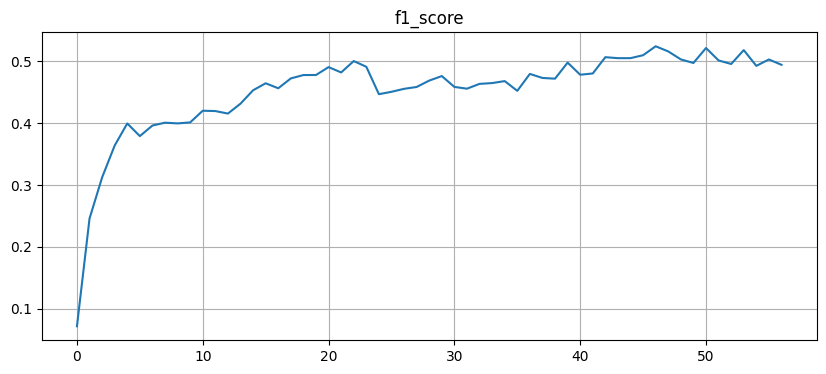

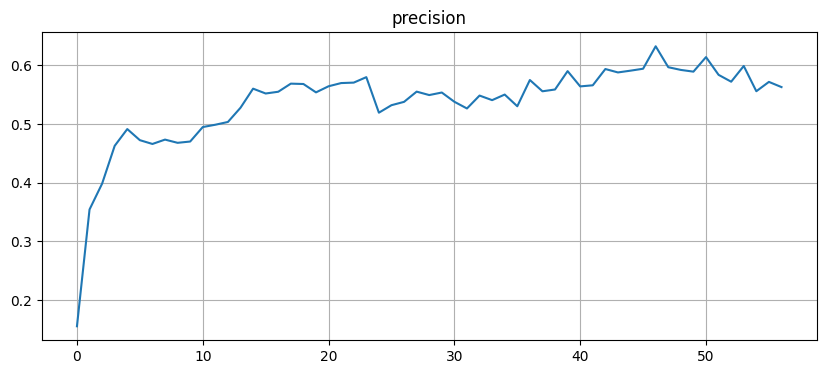

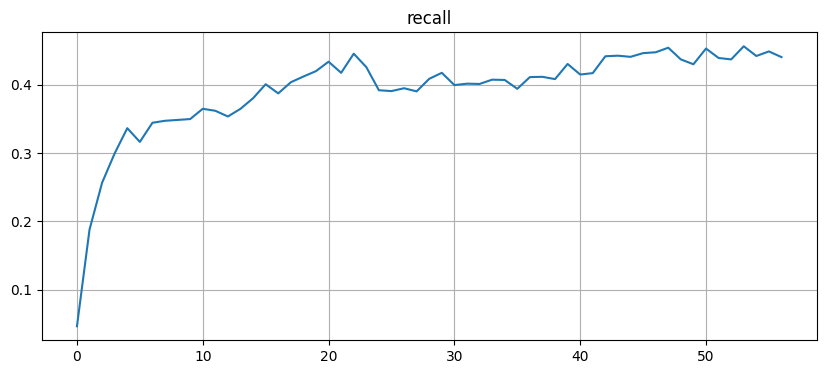

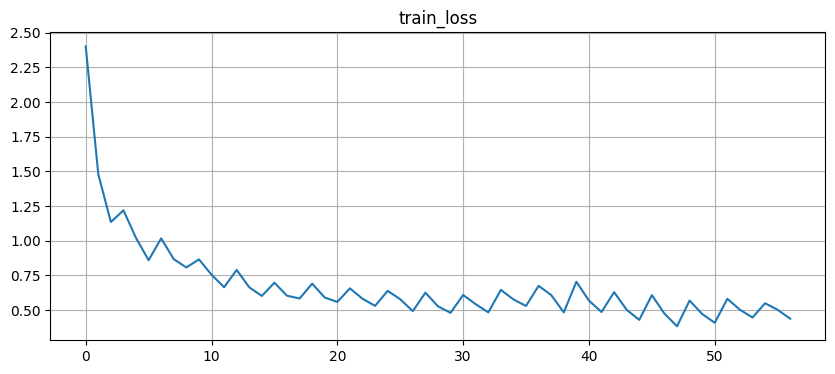

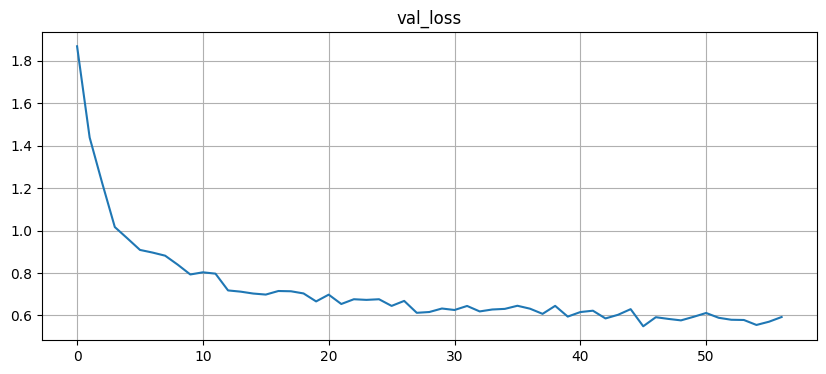

In [ ]:
for i, (name, history) in enumerate (sorted (metrics.items ())):
    #plt.plot (1, len (metrics), i + 1)
    plt.figure (figsize = (10, 4))
    plt.title (name)
    plt.plot (*zip (*history))
    plt.grid ()
    plt.show ()

In [ ]:


model.eval ()  # Устанавливаем модель в режим оценки
val_preds, val_labels_fromdata = [], []

with torch.no_grad ():
    for batch in tqdm (val_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask)

        val_preds.extend (out)
        val_labels_fromdata.extend (labels)
        torch.cuda.empty_cache ()

    print ('Validation: ', sanity_check (val_preds, val_labels_fromdata))


val_preds, val_labels_fromdata = [], []

with torch.no_grad ():
    for batch in tqdm (test_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask)

        val_preds.extend (out)
        val_labels_fromdata.extend (labels)
        torch.cuda.empty_cache ()

    print ('Test: ', sanity_check (val_preds, val_labels_fromdata))


100%|██████████| 38/38 [00:14<00:00,  2.54it/s]


Validation:  (0.563034188034188, 0.4406354515050167, 0.4943714821763603)


100%|██████████| 44/44 [00:17<00:00,  2.55it/s]


Test:  (0.5782149712092131, 0.45904761904761904, 0.5117859418135486)


In [ ]:

val_preds, val_labels_fromdata = [], []
with torch.no_grad ():
    for batch in tqdm (val_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

        val_preds.extend (out)
        val_labels_fromdata.extend (labels)
        torch.cuda.empty_cache ()

    print ('Validation wmax: ', sanity_check (val_preds, val_labels_fromdata))

val_preds, val_labels_fromdata = [], []
with torch.no_grad ():
    for batch in tqdm (test_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

        val_preds.extend (out)
        val_labels_fromdata.extend (labels)
        torch.cuda.empty_cache ()

    print ('Test wmax: ', sanity_check (val_preds, val_labels_fromdata))


100%|██████████| 38/38 [01:18<00:00,  2.07s/it]


Validation wmax:  (0.5928231417063347, 0.6768394648829431, 0.6320515323052899)


100%|██████████| 44/44 [01:20<00:00,  1.82s/it]


Test wmax:  (0.6284039986211651, 0.6944761904761905, 0.659790083242852)


In [ ]:
#model.save_pretrained ('./rut5base_fulltrain_novalid_dictionary_postfix')
#tokenizer.save_pretrained ('./rut5base_fulltrain_novalid_dictionary_postfix')

In [ ]:
print (val_parallel_text [6])
predicted_set = get_set (val_preds [6], ground_truth = False)
predicted_set

Такие сети отображаются на XML-файлы, которые служат для организации Баз Знаний, соответствующих семантических поисков, для решения логико-аналитических задач, а также для автоматического заполнения реляционных БД.


{'3-граммной моделью',
 'базовой 3-граммной моделью',
 'интерполированных',
 'моделью',
 'распознавания',
 'распознавания слов',
 'речи',
 'сверхбольшим словарем',
 'слитной русской речи',
 'слов',
 'словарем',
 'факторных моделей языка'}

In [ ]:
print 4

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(...)? (928237153.py, line 1)

In [ ]:
model = MT5ForConditionalGeneration.from_pretrained ('./coint_rut5small_finetune_fulltrain_novalid')

model.to (device)
print (model.device)

In [ ]:
val_data = tokenizer (parallel_text_val_new, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
val_labels = tokenizer (parallel_label_val, padding = 'max_length', truncation = True, max_length = ANSWER_MAX_LENGTH, return_tensors = 'pt')

if ENABLE_LABEL_FIX:
    rse = replace_padding (val_labels)
    val_labels = rse

val_dataset = Seq2SeqDataset (val_data, val_labels)

val_loader = DataLoader (val_dataset, batch_size = EVAL_BATCH_SIZE)

In [ ]:
val_preds, val_labels = [], []
with torch.no_grad ():
    for batch in tqdm (val_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

        val_preds.extend (out)
        val_labels.extend (labels)
        torch.cuda.empty_cache ()

    print ('Validation augmented: ', sanity_check (val_preds, val_labels))

In [ ]:

parallel_text_val_augmented = []
for i in range (len (val_preds)):
    predicted_set = get_set (val_preds [i], ground_truth = False)
    parallel_text_val_augmented.append (make_attachment (val_parallel_text [i], predicted_set))

val_data = tokenizer (parallel_text_val_augmented, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
val_labels = tokenizer (val_parallel_labels, padding = 'max_length', truncation = True, max_length = ANSWER_MAX_LENGTH, return_tensors = 'pt')

if ENABLE_LABEL_FIX:
    rse = replace_padding (val_labels)
    val_labels = rse

val_dataset = Seq2SeqDataset (val_data, val_labels)

val_loader = DataLoader (val_dataset, batch_size = EVAL_BATCH_SIZE)

In [ ]:
val_preds, val_labels = [], []
with torch.no_grad ():
    for batch in tqdm (val_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

        val_preds.extend (out)
        val_labels.extend (labels)
        torch.cuda.empty_cache ()

    print ('Validation augmented: ', sanity_check (val_preds, val_labels))

In [ ]:
prev_model = MT5ForConditionalGeneration.from_pretrained ('./coint_rut5small_finetune_fulltrain_novalid')

prev_model.to (device)
print (prev_model.device)

In [ ]:

val_data = tokenizer (parallel_text_val, padding = 'max_length', truncation = True, max_length = 150, return_tensors = 'pt')
val_labels = tokenizer (parallel_label_val, padding = 'max_length', truncation = True, max_length = 150, return_tensors = 'pt')

if ENABLE_LABEL_FIX:
    rse = replace_padding (val_labels)
    val_labels = rse

val_dataset = Seq2SeqDataset (val_data, val_labels)

val_loader = DataLoader (val_dataset, batch_size = EVAL_BATCH_SIZE)

In [ ]:
val_preds, val_labels = [], []
with torch.no_grad ():
    for batch in tqdm (val_loader):
        input_ids = batch ['input_ids'].to (prev_model.device)
        attention_mask = batch ['attention_mask'].to (prev_model.device)
        labels = batch ['labels'].to (prev_model.device)
        out = prev_model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

        val_preds.extend (out)
        val_labels.extend (labels)
        torch.cuda.empty_cache ()

    print ('Validation augmented: ', sanity_check (val_preds, val_labels))

In [ ]:
#model.save_pretrained('./rut5small_fulltrain_novalid_dictionary_postfix')
#tokenizer.save_pretrained('./rut5small_fulltrain_novalid_dictionary_postfix')

In [ ]:
num_epochs = 20
training_steps = len (train_data ['input_ids']) // BATCH_SIZE * num_epochs
warmup_steps = int (training_steps * 0.1)
print (f'Suggested train steps: {training_steps}\n\t warmup steps: {int (training_steps * 0.05)} - {int (training_steps * 0.1)}')

In [ ]:
#optimizer = AdamW (model.parameters (), lr = 1e-5)#, weight_decay = 0.05)
optimizer = AdamW (filter (lambda p: p.requires_grad, model.parameters ()), lr = 5e-5, weight_decay = 0.01)

#optimizer = Adafactor (model.parameters (), lr = 3e-5, scale_parameter = False, relative_step = False, weight_decay = 0.02)

#scheduler = lr_scheduler.StepLR (optimizer, warmup_steps = 637, training_steps = 6375)
scheduler = get_scheduler ('linear', optimizer = optimizer, num_warmup_steps = warmup_steps, num_training_steps = training_steps)

In [ ]:
for epoch in range (num_epochs):
    model.train ()  # Устанавливаем модель в режим обучения
    total_loss = 0
    
    for batch in tqdm (val_loader):
        
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)

        outputs = model (input_ids = input_ids, attention_mask = attention_mask, labels = labels)
        loss = outputs.loss   ## DOUBLE CHECK if padding ...
        total_loss += loss.item ()

        loss.backward ()  # Обратное распространение
        optimizer.step ()  # Обновление параметров
        optimizer.zero_grad ()  # Обнуляем градиенты

        scheduler.step ()  # Обновление learning rate
    

    avg_loss = total_loss / len (train_loader)

    metrics ['train_loss'].append ((epoch, avg_loss))

    # Оценка на валидационной выборке
    model.eval ()  # Устанавливаем модель в режим оценки
    val_preds, val_labels = [], []
    total_val_loss = 0

    with torch.no_grad ():
        for batch in val_loader:
            input_ids = batch ['input_ids'].to (model.device)
            attention_mask = batch ['attention_mask'].to (model.device)
            labels = batch ['labels'].to (model.device)

            outputs = model.generate (input_ids = input_ids, attention_mask = attention_mask)

            total_val_loss += model (input_ids = input_ids, attention_mask = attention_mask, labels = labels).loss.item ()

            val_preds.extend (outputs)
            val_labels.extend (labels)

    avg_val_loss = total_val_loss / len (val_loader)

    prec, recl, f1sc = sanity_check (val_preds, val_labels)

    metrics ['val_loss'].append ((epoch, avg_val_loss))
    metrics ['precision'].append ((epoch, prec))
    metrics ['recall'].append ((epoch, recl))
    metrics ['f1_score'].append ((epoch, f1sc))

    print (f'Epoch {epoch + 1} / {num_epochs}, Loss: {avg_loss:.4f}, Validation loss: {avg_val_loss:.4f}, {prec} / {recl} / {f1sc}')

In [ ]:
#model.save_pretrained('./rut5small_fulltrain_plusvalid')
#tokenizer.save_pretrained('./rut5small_fulltrain_plusvalid')